In [62]:
from keras.datasets import fashion_mnist
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt

import math

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
#from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split
#from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, average_precision_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.utils import shuffle
from sklearn.utils.multiclass import unique_labels

from skimage import exposure, feature, transform
import pickle as pkl
from sklearn.decomposition import PCA

from itertools import product


import seaborn as sns

import time
import timeit
from timeit import default_timer as timer

In [2]:
'''
Datensätze (Grauwertbilder) laden. Die Bilder haben eine Größe von 28x28 Pixel und sind bereits segmentiert, 
jedes enthält nur ein Kleidungsstück

Label Beschreibung
0     T-shirt/top
1     Trousers
2     Pullover
3     Dress
4     Coat
5     Sandal
6     Shirt
7     Sneaker
8     Bag
9     Ankle boot
''' 

# Trainingsmenge (60.000 Bilder, gelabelt) und Testmenge (10.000 Bilder, gelabelt) laden, 
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
print("x_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)
print("x test.shape: ", X_test.shape, " y_test shape: ", y_test.shape)


'''
Normalisieren von [0,255] nach [0,1]

'''
X_train = X_train/255.0
X_test = X_test/255.0

'''
Teilmengen aus Trainingsdatensatz generieren

'''

#Trainingsmenge mit 50.000 Bilder erzeugen
X_train_50000, X_test_10000, y_train_50000, y_test_10000 = train_test_split(X_train, y_train, random_state = 0, test_size=1/6, stratify=y_train)

#Trainingsmenge mit 40.000 Bilder erzeugen
X_train_40000, X_test_10000_b, y_train_40000, y_test_10000_b = train_test_split(X_train_50000, y_train_50000, random_state = 0, test_size=1/5, stratify=y_train_50000)

#Trainingsmenge mit 30.000 Bilder erzeugen
X_train_30000, X_test_10000_c, y_train_30000, y_test_10000_c = train_test_split(X_train_40000, y_train_40000, random_state = 0, test_size=1/4, stratify=y_train_40000)

#Trainingsmenge mit 20.000 Bilder erzeugen
X_train_20000, X_test_10000_d, y_train_20000, y_test_10000_d = train_test_split(X_train_30000, y_train_30000, random_state = 0, test_size=1/3, stratify=y_train_30000)

#Trainingsmenge mit 10.000 Bilder erzeugen
X_train_10000, X_test_10000_e, y_train_10000, y_test_10000_e = train_test_split(X_train_20000, y_train_20000, random_state = 0, test_size=1/2, stratify=y_train_20000)

#Trainingsmenge mit 5.000 Bilder erzeugen
X_train_5000, X_test_5000, y_train_5000, y_test_5000 = train_test_split(X_train_10000, y_train_10000, random_state = 0, test_size=1/2, stratify=y_train_10000)

#Trainingsmenge mit 2.000 Bilder erzeugen
X_train_2000, X_test_3000, y_train_2000, y_test_3000 = train_test_split(X_train_5000, y_train_5000, random_state = 0, test_size=3/5, stratify=y_train_5000)

#Trainingsmenge mit 1.000 Bilder erzeugen
X_train_1000, X_test_1000, y_train_1000, y_test_1000 = train_test_split(X_train_2000, y_train_2000, random_state = 0, test_size=1/2, stratify=y_train_2000)

#Trainingsmenge mit 500 Bilder erzeugen
X_train_500, X_test_500, y_train_500, y_test_500 = train_test_split(X_train_1000, y_train_1000, random_state = 0, test_size=1/2, stratify=y_train_1000)

x_train shape:  (60000, 28, 28) y_train shape:  (60000,)
x test.shape:  (10000, 28, 28)  y_test shape:  (10000,)


In [4]:
'''
speichert trainierte Modelle als Pickle-Datei.
Diese gespeicherten Modelle können mit Funktion   load_trained_model_from_pkl(name)
'''

def save_trained_model_as_pkl(model, filename):
    with open(filename, 'wb') as file:
        pkl.dump(model, file)   

In [5]:
'''
lädt bereits trainiertes, als Pickle-Datei gespeichertes Modell
'''
def load_trained_model_from_pkl(filename):
    with open(filename, 'rb') as file:
        new_model=pkl.load(file)
    return new_model

In [81]:
'''
Erstellt eine nicht normalisierte Konfusionsmatrix 
'''

def plot_confusion_matrix(model, X_test, y_test):
    #y_pred = model.fit(X_train, y_train).predict(X_test)
    y_pred = model.predict(X_test)

    normalize=False
    cmap = plt.cm.Blues
    #cmap = plt.cm.OrRd
    #cmap = plt.cm.YlGn
    #cmap = plt.cm.Greens
    classes = ['T-shirt', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker','Bag', 'Ankle-boot']
    
    title = 'confusion matrix'    
    cm = confusion_matrix(y_test, y_pred)
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel = 'true classes',
          xlabel = 'predicted classes')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    np.set_printoptions(precision=2)
    plt.show()

In [339]:
def plot_confusion_matrix_norm(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    
    classes = ['T-shirt', 'Trousers', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker','Bag', 'Ankle-boot']
    
    cm = confusion_matrix(y_test, y_pred)
    
    
    np.set_printoptions(precision=3)
    
    plt.figure(figsize=(4.5*2, 2.5*2))
    
    normalize=True
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            
    #for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()



C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


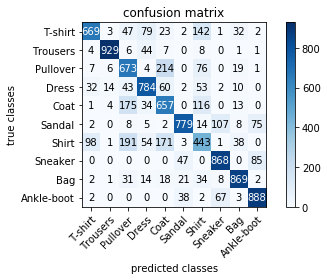

In [7]:
m = LinearSVC()
m.fit(X_train_500.reshape(-1,784), y_train_500)
plot_confusion_mat(m, X_test.reshape(-1,784), y_test)

Normalized confusion matrix


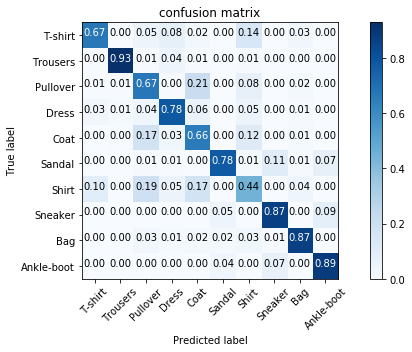

In [90]:
plot_confusion_matrix_norm(m, X_test.reshape(-1,784), y_test)

In [92]:
np.logspace(-6,10,17)

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09,
       1.e+10])

In [95]:
b = np.logspace(-6,10,17)
if 10**-6 in b:
    print("treffer")

treffer


In [96]:
np.logspace(-6,10,17,base=2.0)

array([1.562e-02, 3.125e-02, 6.250e-02, 1.250e-01, 2.500e-01, 5.000e-01,
       1.000e+00, 2.000e+00, 4.000e+00, 8.000e+00, 1.600e+01, 3.200e+01,
       6.400e+01, 1.280e+02, 2.560e+02, 5.120e+02, 1.024e+03])

In [98]:
b.argmax()

16

In [105]:
c=np.logspace(-6,10,17,base=2.0)
print(c)

[1.562e-02 3.125e-02 6.250e-02 1.250e-01 2.500e-01 5.000e-01 1.000e+00
 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.400e+01 1.280e+02
 2.560e+02 5.120e+02 1.024e+03]


In [103]:
b.max()

10000000000.0

In [110]:
np.logspace(-4,2,7)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [145]:
'''
Tuning der Hyperparameter mit GridSearchCV
'''

def tuning_hyper_params(X, y, kernel, cv, scoring, c_range, gamma_range):
    
    param_grid=[]
    scores = scoring
    if kernel == 'linear':
        param_grid = [{'kernel':['linear'],
                     'C': c_range}]
    elif kernel == 'poly':
        param_grid = [{'kernel':['poly'],
                      'C': c_range,
                      'gamma': gamma_range,
                      'degree': [1,2,3]}]
        
    elif kernel == 'rbf':
        param_grid = [{'kernel': ['rbf'],
                     'C': c_range,
                      'gamma': gamma_range}]
    elif kernel == 'sigmoid':
        param_grid = [{'kernel': ['sigmoid'],
                      'C': c_range,
                      'gamma': gamma_range}]
    else:
        print("Fehlerhafte Eingabe")
        
    
    print("Tuning Hyperparameter zu Score", scoring)
    print()
    clf = GridSearchCV(SVC(), param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    start=time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    clf.fit(X,y)
    print("Zeit für Suche: ", time.time()-start)
    print("Zeit für Suche: ", time.process_time()-start2)
    print("Zeit für Suche: ", time.perf_counter()-start3)
        
    print("Besten gefundenen Parameter lauten:")
    print()
    print(clf.best_params_)
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    #params = clf.cv_results_['params']
    
    #for mean, stdev, param in zip(means, stds, params):
     #   print("%f (%f) mit: %r" % (mean, stdev, param))
        
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
             % (mean, std * 2, params))
    print()
    print("Klassifikationsreport")
    print()
    y_true, y_pred = y_test, clf.predict(X_test.reshape(-1,784))
    print(classification_report(y_true, y_pred))
    print()
    return clf                             
                

In [250]:
'''
Tuning des Hyperparameters C von LinearSVC
'''

def tuning_hyper_param_LinearSVC(X, y, cv, scoring, c_range):
    param_grid=[{'C': c_range}]
    print("Tuning des Hyperparameters C zu Score", scoring)
    print()
    clf=GridSearchCV(LinearSVC(), param_grid, cv=cv, scoring=scoring, n_jobs=-1)
    start=time.time()
    start2 = time.process_time()
    start3 = time.perf_counter()
    clf.fit(X,y)
    print("Zeit für Suche: ", time.time()-start)
    print("Zeit für Suche: ", time.process_time()-start2)
    print("Zeit für Suche: ", time.perf_counter()-start3)
        
    print("Besten gefundenen Parameter lauten:")
    print()
    print(clf.best_params_)
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
            
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
             % (mean, std * 2, params))
    print()
    print("Klassifikationsreport")
    print()
    y_true, y_pred = y_test, clf.predict(X_test.reshape(-1,784))
    print(classification_report(y_true, y_pred))
    print()
    return clf                             
    

In [ ]:
'''
TRAININGSMENGE 500

'''

In [193]:
gs_linearSVC_cv5_500= tuning_hyper_param_LinearSVC(X_train_500.reshape(-1,784),y_train_500,
                                                   5, 'accuracy', np.logspace(-4,2,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  15.03300952911377
Zeit für Suche:  0.9516060999999922
Zeit für Suche:  15.033921004026524
Besten gefundenen Parameter lauten:

{'C': 0.1}

0.658 (+/-0.043) for {'C': 0.0001}
0.706 (+/-0.047) for {'C': 0.001}
0.776 (+/-0.073) for {'C': 0.01}
0.778 (+/-0.048) for {'C': 0.1}
0.764 (+/-0.037) for {'C': 1.0}
0.758 (+/-0.043) for {'C': 10.0}
0.760 (+/-0.033) for {'C': 100.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1000
           1       0.97      0.94      0.95      1000
           2       0.60      0.69      0.64      1000
           3       0.78      0.82      0.80      1000
           4       0.60      0.71      0.65      1000
           5       0.88      0.80      0.84      1000
           6       0.55      0.42      0.48      1000
           7       0.83      0.86      0.85      1000
           8       0.89      0.90      0.89      1000

In [194]:
gs_linearSVC_cv5_500.score(X_test.reshape(-1,784), y_test)

0.7745

In [195]:
gs_linearSVC_cv10_500= tuning_hyper_param_LinearSVC(X_train_500.reshape(-1,784),y_train_500,
                                                   10, 'accuracy', np.logspace(-4,2,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  26.710525274276733
Zeit für Suche:  1.0920069999999669
Zeit für Suche:  26.71311504638561
Besten gefundenen Parameter lauten:

{'C': 0.1}

0.662 (+/-0.052) for {'C': 0.0001}
0.704 (+/-0.056) for {'C': 0.001}
0.772 (+/-0.097) for {'C': 0.01}
0.780 (+/-0.101) for {'C': 0.1}
0.764 (+/-0.094) for {'C': 1.0}
0.762 (+/-0.090) for {'C': 10.0}
0.764 (+/-0.089) for {'C': 100.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.82      0.69      0.75      1000
           1       0.97      0.94      0.95      1000
           2       0.60      0.69      0.64      1000
           3       0.78      0.82      0.80      1000
           4       0.60      0.71      0.65      1000
           5       0.88      0.80      0.84      1000
           6       0.55      0.42      0.48      1000
           7       0.83      0.86      0.85      1000
           8       0.89      0.90      0.89      1000

In [196]:
gs_linearSVC_cv10_500.score(X_test.reshape(-1,784), y_test)

0.7745

In [199]:
#Finetuning
gs_linearSVC_cv10_500B= tuning_hyper_param_LinearSVC(X_train_500.reshape(-1,784),y_train_500,
                                                   10, 'accuracy', np.logspace(-2,0,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  18.827457904815674
Zeit für Suche:  0.4836030999999821
Zeit für Suche:  18.835234875124115
Besten gefundenen Parameter lauten:

{'C': 0.03162277660168379}

0.772 (+/-0.097) for {'C': 0.01}
0.788 (+/-0.115) for {'C': 0.03162277660168379}
0.780 (+/-0.101) for {'C': 0.1}
0.770 (+/-0.092) for {'C': 0.31622776601683794}
0.766 (+/-0.091) for {'C': 1.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.81      0.72      0.76      1000
           1       0.97      0.94      0.95      1000
           2       0.61      0.68      0.65      1000
           3       0.78      0.84      0.81      1000
           4       0.60      0.73      0.65      1000
           5       0.90      0.80      0.85      1000
           6       0.57      0.38      0.46      1000
           7       0.83      0.86      0.85      1000
           8       0.88      0.92      0.90      1000
           9       0.8

In [200]:
gs_linearSVC_cv10_500B.score(X_test.reshape(-1,784), y_test)

0.7785

In [202]:
#Finetuning
gs_linearSVC_cv10_500C= tuning_hyper_param_LinearSVC(X_train_500.reshape(-1,784),y_train_500,
                                                   10, 'accuracy', np.logspace(-2,-1,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  12.398997068405151
Zeit für Suche:  0.5460034999999834
Zeit für Suche:  12.40080321838468
Besten gefundenen Parameter lauten:

{'C': 0.01778279410038923}

0.772 (+/-0.097) for {'C': 0.01}
0.790 (+/-0.098) for {'C': 0.01778279410038923}
0.788 (+/-0.115) for {'C': 0.03162277660168379}
0.780 (+/-0.129) for {'C': 0.05623413251903491}
0.780 (+/-0.101) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1000
           1       0.97      0.94      0.95      1000
           2       0.62      0.67      0.64      1000
           3       0.77      0.83      0.80      1000
           4       0.58      0.74      0.65      1000
           5       0.92      0.78      0.85      1000
           6       0.57      0.35      0.43      1000
           7       0.83      0.86      0.85      1000
           8       0.87      0.94      0.90      1000
       

In [208]:
#Finetuning
gs_linearSVC_cv10_500D= tuning_hyper_param_LinearSVC(X_train_500.reshape(-1,784),y_train_500,
                                                   10, 'accuracy', np.logspace(-2,-1.5,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  11.218955278396606
Zeit für Suche:  0.5616036000000122
Zeit für Suche:  11.227885155411968
Besten gefundenen Parameter lauten:

{'C': 0.01778279410038923}

0.772 (+/-0.097) for {'C': 0.01}
0.778 (+/-0.097) for {'C': 0.01333521432163324}
0.790 (+/-0.098) for {'C': 0.01778279410038923}
0.790 (+/-0.092) for {'C': 0.023713737056616554}
0.788 (+/-0.115) for {'C': 0.03162277660168379}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1000
           1       0.97      0.94      0.95      1000
           2       0.62      0.67      0.64      1000
           3       0.77      0.83      0.80      1000
           4       0.58      0.74      0.65      1000
           5       0.92      0.78      0.85      1000
           6       0.57      0.35      0.43      1000
           7       0.83      0.86      0.85      1000
           8       0.87      0.94      0.90

In [227]:
#Finetuning
gs_linearSVC_cv10_500E= tuning_hyper_param_LinearSVC(X_train_500.reshape(-1,784),y_train_500,
                                                   10, 'accuracy', np.logspace(-2,-1.5,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  13.696622848510742
Zeit für Suche:  0.46800300000001016
Zeit für Suche:  13.69758637373343
Besten gefundenen Parameter lauten:

{'C': 0.01778279410038923}

0.772 (+/-0.097) for {'C': 0.01}
0.780 (+/-0.091) for {'C': 0.012115276586285882}
0.782 (+/-0.097) for {'C': 0.014677992676220698}
0.790 (+/-0.098) for {'C': 0.01778279410038923}
0.790 (+/-0.092) for {'C': 0.021544346900318832}
0.788 (+/-0.098) for {'C': 0.026101572156825358}
0.788 (+/-0.115) for {'C': 0.03162277660168379}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.80      0.73      0.76      1000
           1       0.97      0.94      0.95      1000
           2       0.62      0.67      0.64      1000
           3       0.77      0.83      0.80      1000
           4       0.58      0.74      0.65      1000
           5       0.92      0.78      0.85      1000
           6       0.57      0.35      0.43      100

In [228]:
gs_linearSVC_cv10_500C.score(X_test.reshape(-1,784), y_test)

0.7766

In [146]:
gs_lin_svc_cv5_500 = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'linear', 5, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  8.167435646057129
Zeit für Suche:  0.5148032999999828
Zeit für Suche:  8.165180876092359
Besten gefundenen Parameter lauten:

{'C': 0.1, 'kernel': 'linear'}

0.624 (+/-0.078) for {'C': 0.0001, 'kernel': 'linear'}
0.662 (+/-0.056) for {'C': 0.001, 'kernel': 'linear'}
0.760 (+/-0.047) for {'C': 0.01, 'kernel': 'linear'}
0.798 (+/-0.070) for {'C': 0.1, 'kernel': 'linear'}
0.762 (+/-0.043) for {'C': 1.0, 'kernel': 'linear'}
0.762 (+/-0.043) for {'C': 10.0, 'kernel': 'linear'}
0.762 (+/-0.043) for {'C': 100.0, 'kernel': 'linear'}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1000
           1       0.99      0.93      0.96      1000
           2       0.60      0.69      0.64      1000
           3       0.78      0.81      0.79      1000
           4       0.61      0.70      0.65      1000
           5       0.87      0.88      0.87      1000
        

In [147]:
print(gs_lin_svc_cv5_500.score(X_test.reshape(-1,784), y_test))

0.7867


In [127]:
svc_lin_500 = SVC(kernel='linear', C=0.1)
svc_lin_500.fit(X_train_500.reshape(-1,784), y_train_500)
svc_lin_500.score(X_test.reshape(-1,784), y_test)

0.7867

In [148]:
svc_lin_500.score(X_train_500.reshape(-1,784), y_train_500)

0.978

In [128]:
gs_lin_svc_cv10_500 = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'linear', 10, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Besten gefundenen Parameter lauten:

{'C': 0.1, 'kernel': 'linear'}

0.624 (+/-0.110) for {'C': 0.0001, 'kernel': 'linear'}
0.668 (+/-0.074) for {'C': 0.001, 'kernel': 'linear'}
0.764 (+/-0.114) for {'C': 0.01, 'kernel': 'linear'}
0.804 (+/-0.087) for {'C': 0.1, 'kernel': 'linear'}
0.774 (+/-0.080) for {'C': 1.0, 'kernel': 'linear'}
0.774 (+/-0.080) for {'C': 10.0, 'kernel': 'linear'}
0.774 (+/-0.080) for {'C': 100.0, 'kernel': 'linear'}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1000
           1       0.99      0.93      0.96      1000
           2       0.60      0.69      0.64      1000
           3       0.78      0.81      0.79      1000
           4       0.61      0.70      0.65      1000
           5       0.87      0.88      0.87      1000
           6       0.56      0.43      0.49      1000
           7       0.86      0.88      0.87      1000
      

In [138]:
# Finetuning mit Parametern in engerer Nachbarschaft
lin_svc_cv5_500_B = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'linear', 10, 'accuracy', np.logspace(-2,0,5), np.logspace(-2,0,5))

Tuning Hyperparameter zu Score accuracy

Besten gefundenen Parameter lauten:

{'C': 0.1, 'kernel': 'linear'}

0.764 (+/-0.114) for {'C': 0.01, 'kernel': 'linear'}
0.776 (+/-0.114) for {'C': 0.03162277660168379, 'kernel': 'linear'}
0.804 (+/-0.087) for {'C': 0.1, 'kernel': 'linear'}
0.776 (+/-0.089) for {'C': 0.31622776601683794, 'kernel': 'linear'}
0.774 (+/-0.080) for {'C': 1.0, 'kernel': 'linear'}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1000
           1       0.99      0.93      0.96      1000
           2       0.60      0.69      0.64      1000
           3       0.78      0.81      0.79      1000
           4       0.61      0.70      0.65      1000
           5       0.87      0.88      0.87      1000
           6       0.56      0.43      0.49      1000
           7       0.86      0.88      0.87      1000
           8       0.94      0.91      0.92      1000
           9       0.90      0.9

In [300]:
# Finetuning mit Parametern in engerer Nachbarschaft
lin_svc_cv5_500_C = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'linear', 10, 'accuracy', np.logspace(-1.5,-0.5,5), np.logspace(-1.5,-0.5,5))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  12.214698553085327
Zeit für Suche:  0.6396041000000423
Zeit für Suche:  12.215722608842043
Besten gefundenen Parameter lauten:

{'C': 0.1, 'kernel': 'linear'}

0.776 (+/-0.114) for {'C': 0.03162277660168379, 'kernel': 'linear'}
0.792 (+/-0.097) for {'C': 0.05623413251903491, 'kernel': 'linear'}
0.804 (+/-0.087) for {'C': 0.1, 'kernel': 'linear'}
0.788 (+/-0.080) for {'C': 0.1778279410038923, 'kernel': 'linear'}
0.776 (+/-0.089) for {'C': 0.31622776601683794, 'kernel': 'linear'}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1000
           1       0.99      0.93      0.96      1000
           2       0.60      0.69      0.64      1000
           3       0.78      0.81      0.79      1000
           4       0.61      0.70      0.65      1000
           5       0.87      0.88      0.87      1000
           6       0.56      0.43      0.49      1000
  

In [302]:
# Finetuning mit Parametern in engerer Nachbarschaft
lin_svc_cv5_500_D = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'linear', 10, 'accuracy', np.logspace(-1.25,-0.75,5), np.logspace(-1.25,-0.75,5))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  11.572662115097046
Zeit für Suche:  0.7800049999999601
Zeit für Suche:  11.573882962384232
Besten gefundenen Parameter lauten:

{'C': 0.1, 'kernel': 'linear'}

0.792 (+/-0.097) for {'C': 0.05623413251903491, 'kernel': 'linear'}
0.800 (+/-0.084) for {'C': 0.07498942093324558, 'kernel': 'linear'}
0.804 (+/-0.087) for {'C': 0.1, 'kernel': 'linear'}
0.792 (+/-0.084) for {'C': 0.1333521432163324, 'kernel': 'linear'}
0.788 (+/-0.080) for {'C': 0.1778279410038923, 'kernel': 'linear'}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1000
           1       0.99      0.93      0.96      1000
           2       0.60      0.69      0.64      1000
           3       0.78      0.81      0.79      1000
           4       0.61      0.70      0.65      1000
           5       0.87      0.88      0.87      1000
           6       0.56      0.43      0.49      1000
   

In [308]:
# Finetuning mit Parametern in engerer Nachbarschaft
lin_svc_cv5_500_E = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'linear', 10, 'accuracy', np.logspace(-1.25,-0.75,11), np.logspace(-1.25,-0.75,11))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  21.651238441467285
Zeit für Suche:  0.8580054999999902
Zeit für Suche:  21.652651204178255
Besten gefundenen Parameter lauten:

{'C': 0.1, 'kernel': 'linear'}

0.792 (+/-0.097) for {'C': 0.05623413251903491, 'kernel': 'linear'}
0.792 (+/-0.093) for {'C': 0.06309573444801933, 'kernel': 'linear'}
0.796 (+/-0.085) for {'C': 0.0707945784384138, 'kernel': 'linear'}
0.800 (+/-0.084) for {'C': 0.07943282347242814, 'kernel': 'linear'}
0.800 (+/-0.088) for {'C': 0.08912509381337455, 'kernel': 'linear'}
0.804 (+/-0.087) for {'C': 0.1, 'kernel': 'linear'}
0.796 (+/-0.098) for {'C': 0.11220184543019636, 'kernel': 'linear'}
0.794 (+/-0.098) for {'C': 0.12589254117941676, 'kernel': 'linear'}
0.790 (+/-0.080) for {'C': 0.14125375446227545, 'kernel': 'linear'}
0.788 (+/-0.084) for {'C': 0.15848931924611134, 'kernel': 'linear'}
0.788 (+/-0.080) for {'C': 0.1778279410038923, 'kernel': 'linear'}

Klassifikationsreport

              precision    r

In [150]:
gs_rbf_svc_cv5_500 = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'rbf', 5, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  86.12806272506714
Zeit für Suche:  1.357208700000001
Zeit für Suche:  86.13413649768904
Besten gefundenen Parameter lauten:

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}

0.628 (+/-0.077) for {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.640 (+/-0.061) for {'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}
0.690 (+/-0.033) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.454 (+/-0.098) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.148 (+/-0.050) for {'C': 0.0001, 'gamma': 1.0, 'kernel': 'rbf'}
0.708 (+/-0.069) for {'C': 0.0001, 'gamma': 10.0, 'kernel': 'rbf'}
0.108 (+/-0.008) for {'C': 0.0001, 'gamma': 100.0, 'kernel': 'rbf'}
0.628 (+/-0.077) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.640 (+/-0.061) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.690 (+/-0.033) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.454 (+/-0.098) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.148 (+/-0.050) for {'C': 0.001, '

In [153]:
gs_rbf_svc_cv5_500.score(X_test.reshape(-1,784), y_test)

0.795

In [156]:
np.logspace(-3,-1,5)

array([0.001, 0.003, 0.01 , 0.032, 0.1  ])

In [157]:
#Finetuning in der engeren Nachbarschaft
gs_rbf_svc_cv5_500 = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'rbf', 5, 'accuracy', np.logspace(0,2,5), np.logspace(-3,-1,5))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  32.87566828727722
Zeit für Suche:  0.7332046999999875
Zeit für Suche:  32.891132342608216
Besten gefundenen Parameter lauten:

{'C': 3.1622776601683795, 'gamma': 0.01, 'kernel': 'rbf'}

0.698 (+/-0.056) for {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.756 (+/-0.037) for {'C': 1.0, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.760 (+/-0.046) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.774 (+/-0.043) for {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
0.668 (+/-0.053) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.752 (+/-0.027) for {'C': 3.1622776601683795, 'gamma': 0.001, 'kernel': 'rbf'}
0.774 (+/-0.064) for {'C': 3.1622776601683795, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.796 (+/-0.060) for {'C': 3.1622776601683795, 'gamma': 0.01, 'kernel': 'rbf'}
0.782 (+/-0.039) for {'C': 3.1622776601683795, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
0.680 (+/-0.061) for {'C': 3.1622776601683795, 'gamma':

In [158]:
gs_rbf_svc_cv5_500.score(X_test.reshape(-1,784), y_test)

0.7943

In [163]:
np.logspace(0,1,5)

array([ 1.   ,  1.778,  3.162,  5.623, 10.   ])

In [164]:
#Finetuning in der engeren Nachbarschaft
gs_rbf_svc_cv5_500C = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'rbf', 5, 'accuracy', np.logspace(0,1,5), np.logspace(-3,-1,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  51.64501452445984
Zeit für Suche:  0.9516060999999922
Zeit für Suche:  51.659908615775294
Besten gefundenen Parameter lauten:

{'C': 3.1622776601683795, 'gamma': 0.01, 'kernel': 'rbf'}

0.698 (+/-0.056) for {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.740 (+/-0.025) for {'C': 1.0, 'gamma': 0.0021544346900318843, 'kernel': 'rbf'}
0.752 (+/-0.032) for {'C': 1.0, 'gamma': 0.004641588833612777, 'kernel': 'rbf'}
0.760 (+/-0.046) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.780 (+/-0.058) for {'C': 1.0, 'gamma': 0.021544346900318832, 'kernel': 'rbf'}
0.766 (+/-0.057) for {'C': 1.0, 'gamma': 0.046415888336127774, 'kernel': 'rbf'}
0.668 (+/-0.053) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.738 (+/-0.039) for {'C': 1.7782794100389228, 'gamma': 0.001, 'kernel': 'rbf'}
0.754 (+/-0.027) for {'C': 1.7782794100389228, 'gamma': 0.0021544346900318843, 'kernel': 'rbf'}
0.754 (+/-0.039) for {'C': 1.7782794100389228, 'gamma': 0.004641588

In [165]:
gs_rbf_svc_cv5_500C.score(X_test.reshape(-1,784), y_test)

0.7943

In [309]:
#mit cv=10
gs_rbf_svc_cv10_500 = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'rbf', 10, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  193.92609190940857
Zeit für Suche:  2.012412900000072
Zeit für Suche:  193.92860263017064
Besten gefundenen Parameter lauten:

{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}

0.624 (+/-0.106) for {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.634 (+/-0.084) for {'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}
0.688 (+/-0.078) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.460 (+/-0.098) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.148 (+/-0.065) for {'C': 0.0001, 'gamma': 1.0, 'kernel': 'rbf'}
0.710 (+/-0.082) for {'C': 0.0001, 'gamma': 10.0, 'kernel': 'rbf'}
0.112 (+/-0.027) for {'C': 0.0001, 'gamma': 100.0, 'kernel': 'rbf'}
0.624 (+/-0.106) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.634 (+/-0.084) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.688 (+/-0.078) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.460 (+/-0.098) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.148 (+/-0.065) for {'C': 0.001

In [316]:
gs_rbf_svc_cv10_500B = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'rbf', 10, 'accuracy', np.logspace(0,3,9), np.logspace(-3,-1,5))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  134.31368207931519
Zeit für Suche:  2.262014499999964
Zeit für Suche:  134.31395416687155
Besten gefundenen Parameter lauten:

{'C': 5.623413251903491, 'gamma': 0.01, 'kernel': 'rbf'}

0.716 (+/-0.064) for {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.746 (+/-0.065) for {'C': 1.0, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.760 (+/-0.101) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.782 (+/-0.107) for {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
0.670 (+/-0.084) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.746 (+/-0.086) for {'C': 2.371373705661655, 'gamma': 0.001, 'kernel': 'rbf'}
0.764 (+/-0.120) for {'C': 2.371373705661655, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.782 (+/-0.109) for {'C': 2.371373705661655, 'gamma': 0.01, 'kernel': 'rbf'}
0.790 (+/-0.090) for {'C': 2.371373705661655, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
0.686 (+/-0.095) for {'C': 2.371373705661655, 'gamma': 0.1, 

In [327]:
gs_rbf_svc_cv10_500C = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'rbf', 10, 'accuracy', np.logspace(0,1.5,9), np.logspace(-2.5,-1.5,5))

Tuning Hyperparameter zu Score accuracy



C:\Users\Martins-Lapt\AppData\Local\conda\conda\envs\python36\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Zeit für Suche:  133.8016529083252
Zeit für Suche:  2.3556151000000227
Zeit für Suche:  133.8025420796148
Besten gefundenen Parameter lauten:

{'C': 5.623413251903491, 'gamma': 0.01, 'kernel': 'rbf'}

0.746 (+/-0.065) for {'C': 1.0, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.754 (+/-0.088) for {'C': 1.0, 'gamma': 0.005623413251903491, 'kernel': 'rbf'}
0.760 (+/-0.101) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.764 (+/-0.099) for {'C': 1.0, 'gamma': 0.01778279410038923, 'kernel': 'rbf'}
0.782 (+/-0.107) for {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
0.752 (+/-0.088) for {'C': 1.539926526059492, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.758 (+/-0.112) for {'C': 1.539926526059492, 'gamma': 0.005623413251903491, 'kernel': 'rbf'}
0.772 (+/-0.115) for {'C': 1.539926526059492, 'gamma': 0.01, 'kernel': 'rbf'}
0.786 (+/-0.115) for {'C': 1.539926526059492, 'gamma': 0.01778279410038923, 'kernel': 'rbf'}
0.790 (+/-0.095) for {'C': 1.539926526059492, 'gamma': 0

In [331]:
gs_rbf_svc_cv10_500D = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'rbf', 10, 'accuracy', np.logspace(0,1.5,11), np.logspace(-2.5,-1.5,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  205.59875965118408
Zeit für Suche:  3.026419400000009
Zeit für Suche:  205.5986959351212
Besten gefundenen Parameter lauten:

{'C': 5.623413251903491, 'gamma': 0.01, 'kernel': 'rbf'}

0.746 (+/-0.065) for {'C': 1.0, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.758 (+/-0.081) for {'C': 1.0, 'gamma': 0.004641588833612777, 'kernel': 'rbf'}
0.754 (+/-0.095) for {'C': 1.0, 'gamma': 0.006812920690579615, 'kernel': 'rbf'}
0.760 (+/-0.101) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.762 (+/-0.100) for {'C': 1.0, 'gamma': 0.01467799267622069, 'kernel': 'rbf'}
0.772 (+/-0.097) for {'C': 1.0, 'gamma': 0.021544346900318832, 'kernel': 'rbf'}
0.782 (+/-0.107) for {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
0.752 (+/-0.084) for {'C': 1.4125375446227544, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.758 (+/-0.103) for {'C': 1.4125375446227544, 'gamma': 0.004641588833612777, 'kernel': 'rbf'}
0.756 (+/-0.098) for {'C

In [336]:
gs_rbf_svc_cv10_500E = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'rbf', 10, 'accuracy', np.logspace(0,1.5,13), np.logspace(-2.5,-1.5,9))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  309.23968744277954
Zeit für Suche:  4.992031999999995
Zeit für Suche:  309.24001244822284
Besten gefundenen Parameter lauten:

{'C': 4.216965034285822, 'gamma': 0.01, 'kernel': 'rbf'}

0.746 (+/-0.065) for {'C': 1.0, 'gamma': 0.0031622776601683794, 'kernel': 'rbf'}
0.752 (+/-0.076) for {'C': 1.0, 'gamma': 0.004216965034285823, 'kernel': 'rbf'}
0.754 (+/-0.088) for {'C': 1.0, 'gamma': 0.005623413251903491, 'kernel': 'rbf'}
0.756 (+/-0.098) for {'C': 1.0, 'gamma': 0.007498942093324558, 'kernel': 'rbf'}
0.760 (+/-0.101) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.760 (+/-0.101) for {'C': 1.0, 'gamma': 0.01333521432163324, 'kernel': 'rbf'}
0.764 (+/-0.099) for {'C': 1.0, 'gamma': 0.01778279410038923, 'kernel': 'rbf'}
0.780 (+/-0.107) for {'C': 1.0, 'gamma': 0.023713737056616554, 'kernel': 'rbf'}
0.782 (+/-0.107) for {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'rbf'}
0.752 (+/-0.078) for {'C': 1.333521432163324, 'gamma': 

              precision    recall  f1-score   support

           0       0.81      0.71      0.75      1000
           1       0.99      0.93      0.96      1000
           2       0.67      0.66      0.67      1000
           3       0.77      0.83      0.79      1000
           4       0.63      0.73      0.68      1000
           5       0.88      0.91      0.89      1000
           6       0.53      0.49      0.51      1000
           7       0.88      0.88      0.88      1000
           8       0.94      0.91      0.92      1000
           9       0.91      0.91      0.91      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000




In [337]:
gs_rbf_svc_cv10_500E.score(X_test.reshape(-1,784), y_test)

0.7953

In [338]:
gs_rbf_svc_cv10_500D.score(X_test.reshape(-1,784), y_test)

0.7949

In [335]:
np.logspace(-2.5,-1.5,9)

array([0.003, 0.004, 0.006, 0.007, 0.01 , 0.013, 0.018, 0.024, 0.032])

In [182]:
gs_sig_svc_cv10_500 = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'sigmoid', 10, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  187.19908142089844
Zeit für Suche:  1.9656125999999858
Zeit für Suche:  187.21002000954695
Besten gefundenen Parameter lauten:

{'C': 100.0, 'gamma': 0.001, 'kernel': 'sigmoid'}

0.624 (+/-0.110) for {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.630 (+/-0.105) for {'C': 0.0001, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.572 (+/-0.076) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.086 (+/-0.074) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.054 (+/-0.065) for {'C': 0.0001, 'gamma': 1.0, 'kernel': 'sigmoid'}
0.100 (+/-0.000) for {'C': 0.0001, 'gamma': 10.0, 'kernel': 'sigmoid'}
0.100 (+/-0.000) for {'C': 0.0001, 'gamma': 100.0, 'kernel': 'sigmoid'}
0.624 (+/-0.110) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.630 (+/-0.105) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.572 (+/-0.076) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.086 (+/-0.074) for {'C': 0.001, 'gamma': 0.1, 'ke

In [151]:
gs_sig_svc_cv5_500 = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'sigmoid', 5, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  79.20970726013184
Zeit für Suche:  1.1232071999999675
Zeit für Suche:  79.22425482875184
Besten gefundenen Parameter lauten:

{'C': 100.0, 'gamma': 0.001, 'kernel': 'sigmoid'}

0.624 (+/-0.078) for {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.630 (+/-0.063) for {'C': 0.0001, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.566 (+/-0.082) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.102 (+/-0.087) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.062 (+/-0.065) for {'C': 0.0001, 'gamma': 1.0, 'kernel': 'sigmoid'}
0.100 (+/-0.000) for {'C': 0.0001, 'gamma': 10.0, 'kernel': 'sigmoid'}
0.100 (+/-0.000) for {'C': 0.0001, 'gamma': 100.0, 'kernel': 'sigmoid'}
0.624 (+/-0.078) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.630 (+/-0.063) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.566 (+/-0.082) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.102 (+/-0.087) for {'C': 0.001, 'gamma': 0.1, 'kern

In [166]:
gs_sig_svc_cv5_500.score(X_test.reshape(-1,784), y_test)

0.786

In [170]:
gs_sig_svc_cv5_500B = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'sigmoid', 5, 'accuracy', np.logspace(1,3,5), np.logspace(-4,-2,5))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  32.32726001739502
Zeit für Suche:  0.7020045000000437
Zeit für Suche:  32.32899333906562
Besten gefundenen Parameter lauten:

{'C': 1000.0, 'gamma': 0.0001, 'kernel': 'sigmoid'}

0.662 (+/-0.056) for {'C': 10.0, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.734 (+/-0.048) for {'C': 10.0, 'gamma': 0.00031622776601683794, 'kernel': 'sigmoid'}
0.758 (+/-0.043) for {'C': 10.0, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.764 (+/-0.041) for {'C': 10.0, 'gamma': 0.0031622776601683794, 'kernel': 'sigmoid'}
0.450 (+/-0.089) for {'C': 10.0, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.736 (+/-0.052) for {'C': 31.622776601683793, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.760 (+/-0.047) for {'C': 31.622776601683793, 'gamma': 0.00031622776601683794, 'kernel': 'sigmoid'}
0.778 (+/-0.059) for {'C': 31.622776601683793, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.742 (+/-0.061) for {'C': 31.622776601683793, 'gamma': 0.0031622776601683794, 'kernel': 'sigmoid'}
0.428 (+/-

In [171]:
gs_sig_svc_cv5_500B.score(X_test.reshape(-1,784), y_test)

0.7866

In [180]:
gs_sig_svc_cv5_500C = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'sigmoid', 5, 'accuracy', np.logspace(1,4,9), np.logspace(-5,-3,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  72.13572669029236
Zeit für Suche:  1.560009999999977
Zeit für Suche:  72.14726183655057
Besten gefundenen Parameter lauten:

{'C': 10000.0, 'gamma': 1e-05, 'kernel': 'sigmoid'}

0.624 (+/-0.078) for {'C': 10.0, 'gamma': 1e-05, 'kernel': 'sigmoid'}
0.624 (+/-0.078) for {'C': 10.0, 'gamma': 2.1544346900318823e-05, 'kernel': 'sigmoid'}
0.630 (+/-0.078) for {'C': 10.0, 'gamma': 4.641588833612782e-05, 'kernel': 'sigmoid'}
0.662 (+/-0.056) for {'C': 10.0, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.712 (+/-0.056) for {'C': 10.0, 'gamma': 0.00021544346900318823, 'kernel': 'sigmoid'}
0.754 (+/-0.039) for {'C': 10.0, 'gamma': 0.00046415888336127773, 'kernel': 'sigmoid'}
0.758 (+/-0.043) for {'C': 10.0, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.624 (+/-0.078) for {'C': 23.71373705661655, 'gamma': 1e-05, 'kernel': 'sigmoid'}
0.630 (+/-0.068) for {'C': 23.71373705661655, 'gamma': 2.1544346900318823e-05, 'kernel': 'sigmoid'}
0.664 (+/-0.043) for {'

In [181]:
gs_sig_svc_cv5_500C.score(X_test.reshape(-1,784), y_test)

0.7867

In [152]:
gs_poly_svc_cv5_500 = tuning_hyper_params(X_train_500.reshape(-1,784), y_train_500, 'poly', 5, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  168.073388338089
Zeit für Suche:  3.1512201999999547
Zeit für Suche:  168.0661567163272
Besten gefundenen Parameter lauten:

{'C': 0.001, 'degree': 1, 'gamma': 100.0, 'kernel': 'poly'}

0.624 (+/-0.078) for {'C': 0.0001, 'degree': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.624 (+/-0.078) for {'C': 0.0001, 'degree': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.624 (+/-0.078) for {'C': 0.0001, 'degree': 1, 'gamma': 0.01, 'kernel': 'poly'}
0.624 (+/-0.078) for {'C': 0.0001, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
0.624 (+/-0.078) for {'C': 0.0001, 'degree': 1, 'gamma': 1.0, 'kernel': 'poly'}
0.662 (+/-0.056) for {'C': 0.0001, 'degree': 1, 'gamma': 10.0, 'kernel': 'poly'}
0.760 (+/-0.047) for {'C': 0.0001, 'degree': 1, 'gamma': 100.0, 'kernel': 'poly'}
0.464 (+/-0.088) for {'C': 0.0001, 'degree': 2, 'gamma': 0.0001, 'kernel': 'poly'}
0.464 (+/-0.088) for {'C': 0.0001, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
0.464 (+/-0.088) for {

              precision    recall  f1-score   support

           0       0.78      0.73      0.76      1000
           1       0.99      0.93      0.96      1000
           2       0.60      0.69      0.64      1000
           3       0.78      0.81      0.79      1000
           4       0.61      0.70      0.65      1000
           5       0.87      0.88      0.87      1000
           6       0.56      0.43      0.49      1000
           7       0.86      0.88      0.87      1000
           8       0.94      0.91      0.92      1000
           9       0.90      0.90      0.90      1000

   micro avg       0.79      0.79      0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000




In [183]:
'''
TRAININGSMENGE 1000
'''

'\nTRAININGSMENGE 1000\n'

In [209]:
gs_linearSVC_cv10_1000= tuning_hyper_param_LinearSVC(X_train_1000.reshape(-1,784),y_train_1000,
                                                   10, 'accuracy', np.logspace(-4,2,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  53.93213129043579
Zeit für Suche:  0.7332046999999875
Zeit für Suche:  53.93044757685129
Besten gefundenen Parameter lauten:

{'C': 0.01}

0.670 (+/-0.052) for {'C': 0.0001}
0.740 (+/-0.046) for {'C': 0.001}
0.808 (+/-0.051) for {'C': 0.01}
0.790 (+/-0.085) for {'C': 0.1}
0.764 (+/-0.067) for {'C': 1.0}
0.753 (+/-0.079) for {'C': 10.0}
0.755 (+/-0.082) for {'C': 100.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.75      0.77      1000
           1       0.98      0.94      0.96      1000
           2       0.63      0.70      0.66      1000
           3       0.78      0.84      0.81      1000
           4       0.64      0.75      0.69      1000
           5       0.93      0.79      0.86      1000
           6       0.63      0.42      0.50      1000
           7       0.83      0.89      0.86      1000
           8       0.89      0.93      0.91      1000

In [220]:
gs_linearSVC_cv10_1000B= tuning_hyper_param_LinearSVC(X_train_1000.reshape(-1,784),y_train_1000,
                                                   10, 'accuracy', np.logspace(-3,-1,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  24.844284772872925
Zeit für Suche:  1.0452066999999943
Zeit für Suche:  24.836859789724258
Besten gefundenen Parameter lauten:

{'C': 0.03162277660168379}

0.740 (+/-0.046) for {'C': 0.001}
0.774 (+/-0.061) for {'C': 0.0031622776601683794}
0.808 (+/-0.051) for {'C': 0.01}
0.810 (+/-0.072) for {'C': 0.03162277660168379}
0.790 (+/-0.085) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1000
           1       0.98      0.95      0.96      1000
           2       0.63      0.73      0.68      1000
           3       0.78      0.84      0.81      1000
           4       0.67      0.72      0.70      1000
           5       0.92      0.83      0.87      1000
           6       0.59      0.46      0.52      1000
           7       0.85      0.90      0.87      1000
           8       0.90      0.93      0.91      1000
           9      

In [222]:
gs_linearSVC_cv10_1000C= tuning_hyper_param_LinearSVC(X_train_1000.reshape(-1,784),y_train_1000,
                                                   10, 'accuracy', np.logspace(-2,-1,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  35.160017013549805
Zeit für Suche:  1.0140065000000504
Zeit für Suche:  35.16632479976215
Besten gefundenen Parameter lauten:

{'C': 0.03162277660168379}

0.808 (+/-0.051) for {'C': 0.01}
0.809 (+/-0.057) for {'C': 0.01778279410038923}
0.810 (+/-0.072) for {'C': 0.03162277660168379}
0.802 (+/-0.075) for {'C': 0.05623413251903491}
0.790 (+/-0.085) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1000
           1       0.98      0.95      0.96      1000
           2       0.63      0.73      0.68      1000
           3       0.78      0.84      0.81      1000
           4       0.67      0.72      0.70      1000
           5       0.92      0.83      0.87      1000
           6       0.59      0.46      0.52      1000
           7       0.85      0.90      0.87      1000
           8       0.90      0.93      0.91      1000
       

In [224]:
gs_linearSVC_cv10_1000C= tuning_hyper_param_LinearSVC(X_train_1000.reshape(-1,784),y_train_1000,
                                                   10, 'accuracy', np.logspace(-2,-1,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  36.851640462875366
Zeit für Suche:  1.2012077000000545
Zeit für Suche:  36.85820938463257
Besten gefundenen Parameter lauten:

{'C': 0.03162277660168379}

0.808 (+/-0.051) for {'C': 0.01}
0.808 (+/-0.061) for {'C': 0.014677992676220698}
0.807 (+/-0.069) for {'C': 0.021544346900318832}
0.810 (+/-0.072) for {'C': 0.03162277660168379}
0.809 (+/-0.068) for {'C': 0.046415888336127774}
0.796 (+/-0.084) for {'C': 0.06812920690579612}
0.790 (+/-0.085) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1000
           1       0.98      0.95      0.96      1000
           2       0.63      0.73      0.68      1000
           3       0.78      0.84      0.81      1000
           4       0.67      0.72      0.70      1000
           5       0.92      0.83      0.87      1000
           6       0.59      0.46      0.52      1000
           7    

In [225]:
gs_linearSVC_cv10_1000C.score(X_test.reshape(-1,784), y_test)

0.7981

In [223]:
np.logspace(-2,-1,7)

array([0.01 , 0.015, 0.022, 0.032, 0.046, 0.068, 0.1  ])

In [215]:
np.logspace(-4,2,7)

array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])

In [185]:
gs_lin_svc_cv5_1000 = tuning_hyper_params(X_train_1000.reshape(-1,784), y_train_1000, 'linear', 5, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  32.77337074279785
Zeit für Suche:  0.9828063000000498
Zeit für Suche:  32.774121472294155
Besten gefundenen Parameter lauten:

{'C': 0.1, 'kernel': 'linear'}

0.613 (+/-0.051) for {'C': 0.0001, 'kernel': 'linear'}
0.684 (+/-0.033) for {'C': 0.001, 'kernel': 'linear'}
0.777 (+/-0.041) for {'C': 0.01, 'kernel': 'linear'}
0.801 (+/-0.044) for {'C': 0.1, 'kernel': 'linear'}
0.780 (+/-0.067) for {'C': 1.0, 'kernel': 'linear'}
0.780 (+/-0.067) for {'C': 10.0, 'kernel': 'linear'}
0.780 (+/-0.067) for {'C': 100.0, 'kernel': 'linear'}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.77      0.72      0.75      1000
           1       0.99      0.94      0.97      1000
           2       0.63      0.74      0.68      1000
           3       0.78      0.82      0.80      1000
           4       0.69      0.70      0.69      1000
           5       0.88      0.88      0.88      1000
       

In [ ]:
gs_lin_svc_cv5_1000.score(X_test.reshape(-1,784), y_test)

In [189]:
gs_lin_svc_cv5_1000_f1 = tuning_hyper_params(X_train_1000.reshape(-1,784), y_train_1000, 'linear', 5, 'f1', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score f1



ValueError: Target is multiclass but average='binary'. Please choose another average setting.

In [186]:
gs_rbf_svc_cv5_1000 = tuning_hyper_params(X_train_1000.reshape(-1,784), y_train_1000, 'rbf', 5, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  338.7347061634064
Zeit für Suche:  1.8876120999999557
Zeit für Suche:  338.73595745560306
Besten gefundenen Parameter lauten:

{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}

0.613 (+/-0.051) for {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.629 (+/-0.037) for {'C': 0.0001, 'gamma': 0.001, 'kernel': 'rbf'}
0.666 (+/-0.029) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'rbf'}
0.436 (+/-0.085) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'rbf'}
0.134 (+/-0.031) for {'C': 0.0001, 'gamma': 1.0, 'kernel': 'rbf'}
0.754 (+/-0.041) for {'C': 0.0001, 'gamma': 10.0, 'kernel': 'rbf'}
0.118 (+/-0.015) for {'C': 0.0001, 'gamma': 100.0, 'kernel': 'rbf'}
0.613 (+/-0.051) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.629 (+/-0.037) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.666 (+/-0.029) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.436 (+/-0.085) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.134 (+/-0.031) for {'C': 0.001,

In [187]:
gs_sig_svc_cv5_1000 = tuning_hyper_params(X_train_1000.reshape(-1,784), y_train_1000, 'sigmoid', 5, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  354.4841992855072
Zeit für Suche:  1.5132097000000044
Zeit für Suche:  354.4767880341451
Besten gefundenen Parameter lauten:

{'C': 100.0, 'gamma': 0.001, 'kernel': 'sigmoid'}

0.613 (+/-0.051) for {'C': 0.0001, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.618 (+/-0.045) for {'C': 0.0001, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.566 (+/-0.053) for {'C': 0.0001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.122 (+/-0.043) for {'C': 0.0001, 'gamma': 0.1, 'kernel': 'sigmoid'}
0.060 (+/-0.018) for {'C': 0.0001, 'gamma': 1.0, 'kernel': 'sigmoid'}
0.100 (+/-0.000) for {'C': 0.0001, 'gamma': 10.0, 'kernel': 'sigmoid'}
0.100 (+/-0.000) for {'C': 0.0001, 'gamma': 100.0, 'kernel': 'sigmoid'}
0.613 (+/-0.051) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'sigmoid'}
0.618 (+/-0.045) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'sigmoid'}
0.566 (+/-0.053) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}
0.122 (+/-0.043) for {'C': 0.001, 'gamma': 0.1, 'kern

In [188]:
gs_poly_svc_cv5_1000 = tuning_hyper_params(X_train_1000.reshape(-1,784), y_train_1000, 'poly', 5, 'accuracy', np.logspace(-4,2,7), np.logspace(-4,2,7))

Tuning Hyperparameter zu Score accuracy

Zeit für Suche:  726.5227403640747
Zeit für Suche:  3.7284238999999957
Zeit für Suche:  726.5228002667936
Besten gefundenen Parameter lauten:

{'C': 0.001, 'degree': 1, 'gamma': 100.0, 'kernel': 'poly'}

0.613 (+/-0.051) for {'C': 0.0001, 'degree': 1, 'gamma': 0.0001, 'kernel': 'poly'}
0.613 (+/-0.051) for {'C': 0.0001, 'degree': 1, 'gamma': 0.001, 'kernel': 'poly'}
0.613 (+/-0.051) for {'C': 0.0001, 'degree': 1, 'gamma': 0.01, 'kernel': 'poly'}
0.613 (+/-0.051) for {'C': 0.0001, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
0.613 (+/-0.051) for {'C': 0.0001, 'degree': 1, 'gamma': 1.0, 'kernel': 'poly'}
0.684 (+/-0.033) for {'C': 0.0001, 'degree': 1, 'gamma': 10.0, 'kernel': 'poly'}
0.777 (+/-0.041) for {'C': 0.0001, 'degree': 1, 'gamma': 100.0, 'kernel': 'poly'}
0.419 (+/-0.032) for {'C': 0.0001, 'degree': 2, 'gamma': 0.0001, 'kernel': 'poly'}
0.419 (+/-0.032) for {'C': 0.0001, 'degree': 2, 'gamma': 0.001, 'kernel': 'poly'}
0.419 (+/-0.032) for 

              precision    recall  f1-score   support

           0       0.77      0.72      0.75      1000
           1       0.99      0.94      0.97      1000
           2       0.63      0.74      0.68      1000
           3       0.78      0.82      0.80      1000
           4       0.69      0.70      0.70      1000
           5       0.88      0.88      0.88      1000
           6       0.57      0.49      0.53      1000
           7       0.86      0.89      0.88      1000
           8       0.94      0.93      0.94      1000
           9       0.91      0.90      0.90      1000

   micro avg       0.80      0.80      0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000




In [ ]:
'''
TRAININGSMENGE 2000
'''

In [210]:
gs_linearSVC_cv5_2000= tuning_hyper_param_LinearSVC(X_train_2000.reshape(-1,784),y_train_2000,
                                                   5, 'accuracy', np.logspace(-4,2,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  55.5107536315918
Zeit für Suche:  4.0248258000000305
Zeit für Suche:  55.51380245414839
Besten gefundenen Parameter lauten:

{'C': 0.1}

0.671 (+/-0.023) for {'C': 0.0001}
0.765 (+/-0.043) for {'C': 0.001}
0.809 (+/-0.026) for {'C': 0.01}
0.815 (+/-0.021) for {'C': 0.1}
0.785 (+/-0.021) for {'C': 1.0}
0.776 (+/-0.028) for {'C': 10.0}
0.777 (+/-0.021) for {'C': 100.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      1000
           1       0.97      0.95      0.96      1000
           2       0.66      0.73      0.70      1000
           3       0.78      0.84      0.81      1000
           4       0.70      0.69      0.70      1000
           5       0.92      0.86      0.89      1000
           6       0.58      0.50      0.54      1000
           7       0.86      0.91      0.89      1000
           8       0.91      0.91      0.91      1000
 

In [233]:
gs_linearSVC_cv5_2000B= tuning_hyper_param_LinearSVC(X_train_2000.reshape(-1,784),y_train_2000,
                                                   5, 'accuracy', np.logspace(-2,0,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  46.25319504737854
Zeit für Suche:  1.9344123999999852
Zeit für Suche:  46.26893511768685
Besten gefundenen Parameter lauten:

{'C': 0.03162277660168379}

0.809 (+/-0.026) for {'C': 0.01}
0.819 (+/-0.026) for {'C': 0.03162277660168379}
0.815 (+/-0.021) for {'C': 0.1}
0.797 (+/-0.026) for {'C': 0.31622776601683794}
0.787 (+/-0.022) for {'C': 1.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1000
           1       0.98      0.95      0.96      1000
           2       0.68      0.73      0.70      1000
           3       0.78      0.86      0.82      1000
           4       0.71      0.71      0.71      1000
           5       0.93      0.87      0.90      1000
           6       0.61      0.51      0.55      1000
           7       0.86      0.91      0.88      1000
           8       0.91      0.92      0.92      1000
           9       0.90 

In [235]:
gs_linearSVC_cv5_2000C= tuning_hyper_param_LinearSVC(X_train_2000.reshape(-1,784),y_train_2000,
                                                   5, 'accuracy', np.logspace(-2,-1,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  35.4576153755188
Zeit für Suche:  3.2760210000000143
Zeit für Suche:  35.46330124295855
Besten gefundenen Parameter lauten:

{'C': 0.05623413251903491}

0.809 (+/-0.026) for {'C': 0.01}
0.813 (+/-0.018) for {'C': 0.01778279410038923}
0.819 (+/-0.026) for {'C': 0.03162277660168379}
0.819 (+/-0.025) for {'C': 0.05623413251903491}
0.815 (+/-0.021) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.77      0.76      0.76      1000
           1       0.97      0.95      0.96      1000
           2       0.67      0.74      0.70      1000
           3       0.78      0.85      0.81      1000
           4       0.70      0.70      0.70      1000
           5       0.93      0.87      0.90      1000
           6       0.60      0.51      0.55      1000
           7       0.86      0.91      0.89      1000
           8       0.91      0.92      0.92      1000
         

In [237]:
gs_linearSVC_cv5_2000D= tuning_hyper_param_LinearSVC(X_train_2000.reshape(-1,784),y_train_2000,
                                                   5, 'accuracy', np.logspace(-1.5,-1,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  43.637042760849
Zeit für Suche:  2.340014999999994
Zeit für Suche:  43.62778595863165
Besten gefundenen Parameter lauten:

{'C': 0.042169650342858224}

0.819 (+/-0.026) for {'C': 0.03162277660168379}
0.820 (+/-0.027) for {'C': 0.042169650342858224}
0.819 (+/-0.025) for {'C': 0.05623413251903491}
0.819 (+/-0.023) for {'C': 0.07498942093324558}
0.815 (+/-0.021) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1000
           1       0.97      0.95      0.96      1000
           2       0.67      0.73      0.70      1000
           3       0.78      0.85      0.82      1000
           4       0.70      0.71      0.70      1000
           5       0.93      0.87      0.90      1000
           6       0.61      0.51      0.55      1000
           7       0.86      0.91      0.89      1000
           8       0.91      0.92      0.92     

In [238]:
gs_linearSVC_cv5_2000D.score(X_test.reshape(-1,784), y_test)

0.8132

In [246]:
gs_linearSVC_cv5_2000E= tuning_hyper_param_LinearSVC(X_train_2000.reshape(-1,784),y_train_2000,
                                                   5, 'accuracy', np.logspace(-1.5,-1.25,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  34.6519820690155
Zeit für Suche:  2.1996140999999625
Zeit für Suche:  34.653576311418874
Besten gefundenen Parameter lauten:

{'C': 0.042169650342858224}

0.819 (+/-0.026) for {'C': 0.03162277660168379}
0.818 (+/-0.024) for {'C': 0.03651741272548377}
0.820 (+/-0.027) for {'C': 0.042169650342858224}
0.820 (+/-0.026) for {'C': 0.04869675251658631}
0.819 (+/-0.025) for {'C': 0.05623413251903491}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1000
           1       0.97      0.95      0.96      1000
           2       0.67      0.73      0.70      1000
           3       0.78      0.85      0.82      1000
           4       0.70      0.71      0.70      1000
           5       0.93      0.87      0.90      1000
           6       0.61      0.51      0.55      1000
           7       0.86      0.91      0.89      1000
           8       0.91      

In [248]:
gs_linearSVC_cv5_2000F= tuning_hyper_param_LinearSVC(X_train_2000.reshape(-1,784),y_train_2000,
                                                   5, 'accuracy', np.logspace(-1.4375,-1.3125,5))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  36.89656639099121
Zeit für Suche:  2.433615599999996
Zeit für Suche:  36.89104116909584
Besten gefundenen Parameter lauten:

{'C': 0.042169650342858224}

0.818 (+/-0.024) for {'C': 0.03651741272548377}
0.818 (+/-0.026) for {'C': 0.03924189758484536}
0.820 (+/-0.027) for {'C': 0.042169650342858224}
0.819 (+/-0.028) for {'C': 0.04531583637600818}
0.820 (+/-0.026) for {'C': 0.04869675251658631}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1000
           1       0.97      0.95      0.96      1000
           2       0.67      0.73      0.70      1000
           3       0.78      0.85      0.82      1000
           4       0.70      0.71      0.70      1000
           5       0.93      0.87      0.90      1000
           6       0.61      0.51      0.55      1000
           7       0.86      0.91      0.89      1000
           8       0.91      0

In [247]:
np.logspace(-1.4375,-1.3125,5)

array([0.037, 0.039, 0.042, 0.045, 0.049])

In [243]:
jj = LinearSVC(C=0.018)
jj.fit(X_train_2000.reshape(-1,784), y_train_2000)
jj.score(X_test.reshape(-1,784), y_test)

0.8168

In [244]:
jj = LinearSVC(C=0.042169650342858224)
jj.fit(X_train_2000.reshape(-1,784), y_train_2000)
jj.score(X_test.reshape(-1,784), y_test)

0.8132

In [ ]:
'''
TRAININGSMENGE 5000
'''

In [211]:
gs_linearSVC_cv5_5000= tuning_hyper_param_LinearSVC(X_train_5000.reshape(-1,784),y_train_5000,
                                                   5, 'accuracy', np.logspace(-4,2,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  178.9140181541443
Zeit für Suche:  2.932818800000007
Zeit für Suche:  178.9236545423455
Besten gefundenen Parameter lauten:

{'C': 0.01}

0.695 (+/-0.022) for {'C': 0.0001}
0.803 (+/-0.021) for {'C': 0.001}
0.831 (+/-0.011) for {'C': 0.01}
0.819 (+/-0.019) for {'C': 0.1}
0.785 (+/-0.018) for {'C': 1.0}
0.763 (+/-0.023) for {'C': 10.0}
0.758 (+/-0.022) for {'C': 100.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.70      0.74      0.72      1000
           3       0.81      0.85      0.83      1000
           4       0.71      0.75      0.73      1000
           5       0.93      0.89      0.91      1000
           6       0.65      0.48      0.55      1000
           7       0.89      0.91      0.90      1000
           8       0.90      0.95      0.93      1000


In [295]:
gs_linearSVC_cv5_5000B= tuning_hyper_param_LinearSVC(X_train_5000.reshape(-1,784),y_train_5000,
                                                   5, 'accuracy', np.logspace(-3,-1,5))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  89.31847023963928
Zeit für Suche:  2.917218700000035
Zeit für Suche:  89.329371000018
Besten gefundenen Parameter lauten:

{'C': 0.01}

0.803 (+/-0.021) for {'C': 0.001}
0.822 (+/-0.014) for {'C': 0.0031622776601683794}
0.831 (+/-0.011) for {'C': 0.01}
0.829 (+/-0.015) for {'C': 0.03162277660168379}
0.819 (+/-0.019) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.70      0.74      0.72      1000
           3       0.81      0.85      0.83      1000
           4       0.71      0.75      0.73      1000
           5       0.93      0.89      0.91      1000
           6       0.65      0.48      0.55      1000
           7       0.89      0.91      0.90      1000
           8       0.90      0.95      0.93      1000
           9       0.91      0.93    

In [294]:
np.logspace(-3,-1,5)

array([0.001, 0.003, 0.01 , 0.032, 0.1  ])

In [296]:
#nochmal mit cv=10
gs_linearSVC_cv10_5000= tuning_hyper_param_LinearSVC(X_train_5000.reshape(-1,784),y_train_5000,
                                                   10, 'accuracy', np.logspace(-4,2,7))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  583.9465205669403
Zeit für Suche:  2.9796191000000363
Zeit für Suche:  583.9484918280141
Besten gefundenen Parameter lauten:

{'C': 0.01}

0.699 (+/-0.026) for {'C': 0.0001}
0.804 (+/-0.020) for {'C': 0.001}
0.831 (+/-0.028) for {'C': 0.01}
0.825 (+/-0.027) for {'C': 0.1}
0.792 (+/-0.024) for {'C': 1.0}
0.765 (+/-0.021) for {'C': 10.0}
0.756 (+/-0.031) for {'C': 100.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.70      0.74      0.72      1000
           3       0.81      0.85      0.83      1000
           4       0.71      0.75      0.73      1000
           5       0.93      0.89      0.91      1000
           6       0.65      0.48      0.55      1000
           7       0.89      0.91      0.90      1000
           8       0.90      0.95      0.93      100

In [297]:
gs_linearSVC_cv10_5000B= tuning_hyper_param_LinearSVC(X_train_5000.reshape(-1,784),y_train_5000,
                                                   10, 'accuracy', np.logspace(-3,-1,5))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  187.13670372962952
Zeit für Suche:  3.08881980000001
Zeit für Suche:  187.13805655351098
Besten gefundenen Parameter lauten:

{'C': 0.01}

0.804 (+/-0.020) for {'C': 0.001}
0.823 (+/-0.020) for {'C': 0.0031622776601683794}
0.831 (+/-0.028) for {'C': 0.01}
0.830 (+/-0.022) for {'C': 0.03162277660168379}
0.825 (+/-0.027) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.97      0.95      0.96      1000
           2       0.70      0.74      0.72      1000
           3       0.81      0.85      0.83      1000
           4       0.71      0.75      0.73      1000
           5       0.93      0.89      0.91      1000
           6       0.65      0.48      0.55      1000
           7       0.89      0.91      0.90      1000
           8       0.90      0.95      0.93      1000
           9       0.91      0.93 

In [ ]:
'''
TRAININGSMENGE 10000
'''

In [212]:
gs_linearSVC_cv3_10000= tuning_hyper_param_LinearSVC(X_train_10000.reshape(-1,784),y_train_10000,
                                                   3, 'accuracy', np.logspace(-4,2,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  221.56744194030762
Zeit für Suche:  5.912437899999986
Zeit für Suche:  221.57819607735019
Besten gefundenen Parameter lauten:

{'C': 0.01}

0.729 (+/-0.008) for {'C': 0.0001}
0.818 (+/-0.005) for {'C': 0.001}
0.838 (+/-0.009) for {'C': 0.01}
0.836 (+/-0.004) for {'C': 0.1}
0.809 (+/-0.016) for {'C': 1.0}
0.783 (+/-0.015) for {'C': 10.0}
0.768 (+/-0.050) for {'C': 100.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1000
           1       0.97      0.95      0.96      1000
           2       0.70      0.73      0.71      1000
           3       0.82      0.86      0.84      1000
           4       0.71      0.77      0.73      1000
           5       0.94      0.90      0.92      1000
           6       0.65      0.48      0.56      1000
           7       0.89      0.92      0.91      1000
           8       0.91      0.95      0.93      100

In [255]:
gs_linearSVC_cv3_10000B= tuning_hyper_param_LinearSVC(X_train_10000.reshape(-1,784),y_train_10000,
                                                   3, 'accuracy', np.logspace(-3,-1,5))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  112.1016776561737
Zeit für Suche:  12.246078499999953
Zeit für Suche:  112.11522062774384
Besten gefundenen Parameter lauten:

{'C': 0.03162277660168379}

0.818 (+/-0.005) for {'C': 0.001}
0.834 (+/-0.009) for {'C': 0.0031622776601683794}
0.838 (+/-0.009) for {'C': 0.01}
0.838 (+/-0.010) for {'C': 0.03162277660168379}
0.836 (+/-0.004) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.96      0.95      0.96      1000
           2       0.70      0.73      0.72      1000
           3       0.81      0.86      0.84      1000
           4       0.71      0.75      0.73      1000
           5       0.93      0.91      0.92      1000
           6       0.64      0.49      0.55      1000
           7       0.89      0.92      0.91      1000
           8       0.91      0.94      0.93      1000
           9      

In [263]:
gs_linearSVC_cv3_10000C= tuning_hyper_param_LinearSVC(X_train_10000.reshape(-1,784),y_train_10000,
                                                   3, 'accuracy', np.logspace(-3,-1,9))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  153.80095911026
Zeit für Suche:  8.48645440000007
Zeit für Suche:  153.7933011376026
Besten gefundenen Parameter lauten:

{'C': 0.01778279410038923}

0.818 (+/-0.005) for {'C': 0.001}
0.828 (+/-0.008) for {'C': 0.0017782794100389228}
0.834 (+/-0.009) for {'C': 0.0031622776601683794}
0.837 (+/-0.007) for {'C': 0.005623413251903491}
0.838 (+/-0.009) for {'C': 0.01}
0.839 (+/-0.012) for {'C': 0.01778279410038923}
0.838 (+/-0.010) for {'C': 0.03162277660168379}
0.838 (+/-0.008) for {'C': 0.05623413251903491}
0.836 (+/-0.004) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.97      0.95      0.96      1000
           2       0.70      0.73      0.71      1000
           3       0.81      0.86      0.84      1000
           4       0.71      0.76      0.73      1000
           5       0.93      0.90      0.92 

In [270]:
gs_linearSVC_cv3_10000D= tuning_hyper_param_LinearSVC(X_train_10000.reshape(-1,784),y_train_10000,
                                                   3, 'accuracy', np.logspace(-2,-1.5,9))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  127.31695985794067
Zeit für Suche:  8.283653099999924
Zeit für Suche:  127.31879689864218
Besten gefundenen Parameter lauten:

{'C': 0.01778279410038923}

0.838 (+/-0.009) for {'C': 0.01}
0.839 (+/-0.010) for {'C': 0.011547819846894581}
0.839 (+/-0.012) for {'C': 0.01333521432163324}
0.839 (+/-0.013) for {'C': 0.01539926526059492}
0.839 (+/-0.012) for {'C': 0.01778279410038923}
0.839 (+/-0.012) for {'C': 0.02053525026457146}
0.839 (+/-0.011) for {'C': 0.023713737056616554}
0.838 (+/-0.010) for {'C': 0.027384196342643614}
0.838 (+/-0.010) for {'C': 0.03162277660168379}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.97      0.95      0.96      1000
           2       0.70      0.73      0.71      1000
           3       0.81      0.86      0.84      1000
           4       0.71      0.76      0.73      1000
           

In [272]:
gs_linearSVC_cv3_10000E= tuning_hyper_param_LinearSVC(X_train_10000.reshape(-1,784),y_train_10000,
                                                   3, 'accuracy', np.logspace(-1.875,-1.625,9))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  129.96637845039368
Zeit für Suche:  9.391260200000033
Zeit für Suche:  129.96011503260888
Besten gefundenen Parameter lauten:

{'C': 0.019109529749704406}

0.839 (+/-0.012) for {'C': 0.01333521432163324}
0.839 (+/-0.012) for {'C': 0.014330125702369627}
0.839 (+/-0.013) for {'C': 0.01539926526059492}
0.839 (+/-0.012) for {'C': 0.016548170999431813}
0.839 (+/-0.012) for {'C': 0.01778279410038923}
0.839 (+/-0.012) for {'C': 0.019109529749704406}
0.839 (+/-0.012) for {'C': 0.02053525026457146}
0.838 (+/-0.012) for {'C': 0.0220673406908459}
0.839 (+/-0.011) for {'C': 0.023713737056616554}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.96      0.95      0.96      1000
           2       0.70      0.73      0.71      1000
           3       0.81      0.86      0.84      1000
           4       0.71      0.76      0.73      

In [273]:
gs_linearSVC_cv3_10000E.score(X_test.reshape(-1,784), y_test)

0.8315

In [282]:
gs_linearSVC_cv3_10000F= tuning_hyper_param_LinearSVC(X_train_10000.reshape(-1,784),y_train_10000,
                                                   3, 'accuracy', np.logspace(-1.75,-1.6875,9))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  127.45041131973267
Zeit für Suche:  8.704855800000018
Zeit für Suche:  127.45816837681014
Besten gefundenen Parameter lauten:

{'C': 0.019109529749704406}

0.839 (+/-0.012) for {'C': 0.01778279410038923}
0.839 (+/-0.011) for {'C': 0.01810558243027122}
0.839 (+/-0.010) for {'C': 0.018434229924091106}
0.839 (+/-0.011) for {'C': 0.018768842935762187}
0.839 (+/-0.012) for {'C': 0.019109529749704406}
0.839 (+/-0.012) for {'C': 0.019456400615886358}
0.839 (+/-0.012) for {'C': 0.019809567785503388}
0.839 (+/-0.012) for {'C': 0.020169145547303306}
0.839 (+/-0.012) for {'C': 0.02053525026457146}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1000
           1       0.96      0.95      0.96      1000
           2       0.70      0.73      0.71      1000
           3       0.81      0.86      0.84      1000
           4       0.71      0.76      0.73   

In [281]:
np.logspace(-1.75,-1.6875,9)

array([0.018, 0.018, 0.018, 0.019, 0.019, 0.019, 0.02 , 0.02 , 0.021])

In [254]:
np.logspace(-3,-1,5)

array([0.001, 0.003, 0.01 , 0.032, 0.1  ])

In [ ]:
'''
TRAININGSMENGE 20000
'''

In [249]:
gs_linearSVC_cv3_20000= tuning_hyper_param_LinearSVC(X_train_20000.reshape(-1,784),y_train_20000,
                                                   3, 'accuracy', np.logspace(-4,2,7))

Tuning des Hyperparameers C zu Score accuracy

Zeit für Suche:  646.0853595733643
Zeit für Suche:  12.168078000000037
Zeit für Suche:  646.0792557161731
Besten gefundenen Parameter lauten:

{'C': 0.01}

0.764 (+/-0.010) for {'C': 0.0001}
0.828 (+/-0.012) for {'C': 0.001}
0.843 (+/-0.011) for {'C': 0.01}
0.839 (+/-0.013) for {'C': 0.1}
0.822 (+/-0.015) for {'C': 1.0}
0.788 (+/-0.034) for {'C': 10.0}
0.772 (+/-0.006) for {'C': 100.0}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.97      0.95      0.96      1000
           2       0.72      0.73      0.72      1000
           3       0.82      0.87      0.84      1000
           4       0.71      0.76      0.73      1000
           5       0.94      0.91      0.93      1000
           6       0.65      0.51      0.57      1000
           7       0.90      0.92      0.91      1000
           8       0.92      0.95      0.93      1000

In [256]:
gs_linearSVC_cv3_20000B= tuning_hyper_param_LinearSVC(X_train_20000.reshape(-1,784),y_train_20000,
                                                   3, 'accuracy', np.logspace(-3,-1,5))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  235.587749004364
Zeit für Suche:  29.608989799999904
Zeit für Suche:  235.59947800124974
Besten gefundenen Parameter lauten:

{'C': 0.03162277660168379}

0.828 (+/-0.012) for {'C': 0.001}
0.839 (+/-0.008) for {'C': 0.0031622776601683794}
0.843 (+/-0.011) for {'C': 0.01}
0.843 (+/-0.009) for {'C': 0.03162277660168379}
0.839 (+/-0.013) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.97      0.96      0.96      1000
           2       0.71      0.74      0.73      1000
           3       0.82      0.86      0.84      1000
           4       0.72      0.76      0.74      1000
           5       0.94      0.92      0.93      1000
           6       0.65      0.52      0.58      1000
           7       0.90      0.93      0.92      1000
           8       0.92      0.95      0.94      1000
           9       

In [289]:
gs_linearSVC_cv3_20000C= tuning_hyper_param_LinearSVC(X_train_20000.reshape(-1,784),y_train_20000,
                                                   3, 'accuracy', np.logspace(-3,-1,9))

Tuning des Hyperparameters C zu Score accuracy

Zeit für Suche:  324.0572295188904
Zeit für Suche:  18.75132020000001
Zeit für Suche:  324.05254552394763
Besten gefundenen Parameter lauten:

{'C': 0.01778279410038923}

0.828 (+/-0.012) for {'C': 0.001}
0.835 (+/-0.011) for {'C': 0.0017782794100389228}
0.839 (+/-0.008) for {'C': 0.0031622776601683794}
0.843 (+/-0.010) for {'C': 0.005623413251903491}
0.843 (+/-0.011) for {'C': 0.01}
0.844 (+/-0.009) for {'C': 0.01778279410038923}
0.843 (+/-0.009) for {'C': 0.03162277660168379}
0.841 (+/-0.011) for {'C': 0.05623413251903491}
0.839 (+/-0.013) for {'C': 0.1}

Klassifikationsreport

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1000
           1       0.97      0.95      0.96      1000
           2       0.72      0.74      0.73      1000
           3       0.83      0.86      0.84      1000
           4       0.72      0.76      0.74      1000
           5       0.94      0.92      0

In [283]:
np.logspace(-3,-1,9)

array([0.001, 0.002, 0.003, 0.006, 0.01 , 0.018, 0.032, 0.056, 0.1  ])

In [288]:
np.logspace(-2.5,-1,7)

array([0.003, 0.006, 0.01 , 0.018, 0.032, 0.056, 0.1  ])

In [ ]:
'''
TRAININGSMENGE 30000
'''

In [ ]:
'''
TRAININGSMENGE 40000
'''

In [ ]:
'''
TRAININGSMENGE 50000
'''

In [ ]:
'''
TRAININGSMENGE 60000
'''